# Prescriptor Experiments
#### This notebook is to replicate the process used in [Discovering Effective Policies for Land-Use Planning](https://doi.org/10.48550/arXiv.2311.12304)

In [1]:
import os
from pathlib import Path

import torch
from tqdm import tqdm
import pandas as pd
from pymoo.indicators.hv import Hypervolume
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

from data import constants
from data.eluc_data import ELUCData
from prsdk.persistence.serializers.neural_network_serializer import NeuralNetSerializer
from prescriptors.nsga2.candidate import Candidate
from prescriptors.nsga2.land_use_prescriptor import LandUsePrescriptor
from prescriptors.prescriptor_manager import PrescriptorManager
from prescriptors.heuristics.heuristics import EvenHeuristic, PerfectHeuristic, NoCropHeuristic
from prsdk.predictors.neural_network.neural_net_predictor import NeuralNetPredictor
from predictors.percent_change.percent_change_predictor import PercentChangePredictor
from predictors.percent_change.crop_change_predictor import CropChangePredictor

In [15]:
dataset = ELUCData.from_hf()
encoder = dataset.encoder

### Load Results

In [2]:
TOTAL_GENS = 100
# OUTCOMES = ["ELUC", "change", "cropchange"]
OUTCOMES = ["ELUC", "change"]
results_dir = Path("prescriptors/nsga2/training_runs/eds-rhea")

In [3]:
def create_pareto_df(gen: int, results_dir: Path):
    last_gen_filename = results_dir / f"{gen}.csv"
    last_gen_df = pd.read_csv(last_gen_filename)
    pareto_df = last_gen_df[last_gen_df['NSGA-II_rank'] == 1]
    # Sort by first objective, maximize: lowest to highest, minimize: highest to lowest
    pareto_df = pareto_df.sort_values(by='change', ascending=True)
    return pareto_df

In [4]:
pareto_df = create_pareto_df(TOTAL_GENS, results_dir)

### Figure Save Dir

In [5]:
figure_dir = Path("experiments/figures/eds")
figure_dir.mkdir(parents=True, exist_ok=True)

## Generation Plotting

In [6]:
def get_pareto_df(dir, gen):
    """
    Gets the pareto df for a given generation.
    :param dir: The experiment results directory.
    :param gen: The generation to get the pareto df for.
    """
    gen_filename = os.path.join(dir, f"{gen}.csv")
    gen_df = pd.read_csv(gen_filename)
    gen_pareto_df = gen_df[gen_df['NSGA-II_rank'] == 1]
    # Sort by first objective, maximize: lowest to highest, minimize: highest to lowest
    gen_pareto_df = gen_pareto_df.sort_values(by='change', ascending=True)
    gen_pareto_df["Name"] = f"Gen {gen}"
    return gen_pareto_df

def get_merged_df(dir, gens):
    """
    Gets the pareto df for multiple generations and merges them into one.
    :param dir: The experiment results directory.
    :param gens: List of generations to get the pareto df for.
    """
    dfs = []
    for gen in gens:
        dfs.append(get_pareto_df(dir, gen))
    merged_df = pd.concat(dfs, ignore_index=True)
    return merged_df

def get_overall_pareto_df(final_gen: int, results_dir: Path):
    pareto_list = []
    pareto_dfs = []
    for gen in range(1, final_gen + 1):
        gen_path = results_dir / f"{gen}.csv"      
        gen_df = pd.read_csv(gen_path)
        gen_pareto_df = gen_df[gen_df['NSGA-II_rank'] == 1]
        pareto_dfs.append(gen_pareto_df)

    all_pareto_df = pd.concat(pareto_dfs, ignore_index=True)
    all_pareto_df = all_pareto_df.drop_duplicates(subset=["id"])

    for _, add in all_pareto_df.iterrows():
        pareto = True
        for _, compare in all_pareto_df.iterrows():
            dominated = False
            for outcome in OUTCOMES:
                if add[outcome] < compare[outcome]:
                    dominated = False
                    break
                if add[outcome] > compare[outcome]:
                    dominated = True
            if dominated:
                pareto = False
                break
        if pareto:
            pareto_list.append(add)

    return pd.DataFrame(pareto_list)


def plot_gens(dir, gens, outcomes, save_path=None):
    """
    Plots the pareto front for multiple generations.
    :param dir: The experiment results directory.
    :param gens: List of generations to plot the pareto front for.
    """
    merged_df = get_merged_df(dir, gens)
    merged_df = merged_df.sort_values(by=outcomes[0])
    fig, ax = plt.subplots()
    cmap = plt.get_cmap("tab10")
    colors = [cmap(i) for i in [0, 1, 2, 5, 4]]
    curve_names = []
    for i, gen in enumerate(gens):
        curve_name = f"Gen {gen}"
        curve_names.append(curve_name)

        curve = merged_df[merged_df["Name"] == curve_name]
        plt.plot(curve[outcomes[0]], curve[outcomes[1]], color=colors[i], label= "Gen " + str(gen), marker="o")

    overall_pareto_df = get_overall_pareto_df(TOTAL_GENS, dir)

    overall_pareto_df = overall_pareto_df.sort_values(by=outcomes[0])
    plt.plot(overall_pareto_df[outcomes[0]], overall_pareto_df[outcomes[1]], color="r", marker="o", label="Final Pareto Front")
    #plt.xlim(0, 0.4)
    plt.grid() 
    # handles, labels = plt.gca().get_legend_handles_labels()
    # order = [0, 1, 2, 4, 3]
    # plt.legend([handles[idx] for idx in order], [curve_names[idx] for idx in order], loc="upper right")
    plt.xlabel(outcomes[0])
    plt.ylabel(outcomes[1])
    plt.legend(prop={'size': 9})
    #plt.title("Pareto Fronts Across Generations")
    if save_path:
        plt.savefig(save_path, format="png", dpi=300)
    plt.show()

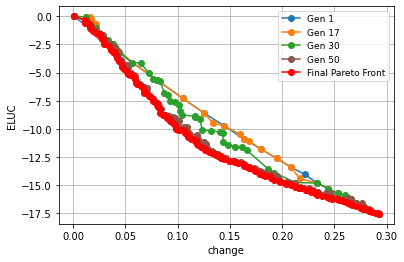

In [7]:
gens_to_plot = [1, 17, 30, 50]
plot_gens(results_dir, gens_to_plot, ["change", "ELUC"], save_path=None)
# plot_gens(results_dir, gens_to_plot, ["cropchange", "ELUC"], save_path=None)
# plot_gens(results_dir, gens_to_plot, ["change", "cropchange"], save_path=None)

170it [00:00, 1382.25it/s]


{'1_1': {'1_1': 1}, '1_3': {'1_3': 1}, '1_6': {'1_6': 1}, '1_9': {'1_9': 1}, '6_59': {'1_3': 2}, '9_49': {'1_3': 3}, '10_3': {'1_3': 5}, '27_49': {'1_3': 6}, '15_54': {'1_3': 6}, '20_37': {'1_3': 4}, '22_79': {'1_3': 10}, '10_41': {'1_3': 3}, '12_63': {'1_3': 4}, '1_15': {'1_15': 1}, '1_7': {'1_7': 1}, '3_15': {'1_15': 1, '1_7': 1}, '6_62': {'1_3': 1, '1_15': 1, '1_7': 1}, '11_79': {'1_3': 4, '1_15': 1, '1_7': 1}, '17_41': {'1_3': 8, '1_15': 1, '1_7': 1}, '20_24': {'1_3': 8}, '22_83': {'1_3': 16, '1_15': 1, '1_7': 1}, '11_47': {'1_3': 6, '1_15': 1, '1_7': 1}, '1_84': {'1_84': 1}, '5_18': {'1_3': 1, '1_84': 1}, '16_21': {'1_3': 2, '1_84': 1, '1_15': 1, '1_7': 1}, '18_13': {'1_3': 8, '1_15': 2, '1_7': 2, '1_84': 1}, '19_39': {'1_3': 14, '1_15': 2, '1_7': 2, '1_84': 1}, '20_40': {'1_3': 15, '1_15': 2, '1_7': 2, '1_84': 1}, '22_18': {'1_3': 23, '1_15': 3, '1_7': 3, '1_84': 1}, '24_25': {'1_3': 39, '1_15': 4, '1_7': 4, '1_84': 1}, '26_42': {'1_3': 49, '1_15': 4, '1_7': 4, '1_84': 1}, '2_42'

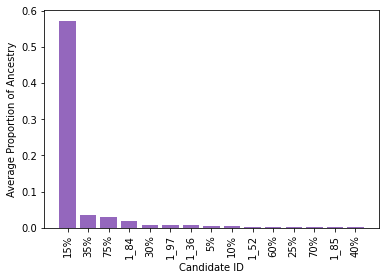

In [37]:
import ast

def get_ancestry(cand_id: str, df: pd.DataFrame, ancestry: dict):
    if cand_id.startswith("1_"):
        ancestry[cand_id] = {cand_id: 1}
    elif cand_id not in ancestry:
        row = df[df["id"] == cand_id].iloc[0]
        parents = ast.literal_eval(row["parents"])

        # Get ancestries of parents
        parent0_ancestry = get_ancestry(parents[0], df, ancestry)
        parent1_ancestry = get_ancestry(parents[1], df, ancestry)

        # Combine ancestries of parents for this candidate
        combined_ancestry = {k: v for k, v in parent0_ancestry.items()}
        for k, v in parent1_ancestry.items():
            combined_ancestry[k] = combined_ancestry.get(k, 0) + v
        
        ancestry[cand_id] = combined_ancestry

    return ancestry[cand_id]

def view_ancestry(save_path=None):
    rhea_dir = Path("prescriptors/nsga2/training_runs/eds-rhea")
    all_dfs = [pd.read_csv(rhea_dir / f"{gen}.csv") for gen in range(1, 101)]
    rhea_df = pd.concat(all_dfs, ignore_index=True).drop_duplicates()
    pareto_df = get_overall_pareto_df(100, rhea_dir)
    ancestry = {}
    for idx, cand_row in tqdm(pareto_df.iterrows()):
        get_ancestry(cand_row["id"], rhea_df, ancestry)

    print(ancestry)
    total_proportions = {}
    for a in ancestry.values():
        total_parents = sum(a.values())
        proportioned = {k: v / total_parents for k, v in a.items()}
        total_proportions = {k: total_proportions.get(k, 0) + v for k, v in proportioned.items()}

    def rename_key(k):
        num = int(k.split("_")[1])
        if num <= 20:
            return f"{num*5}%"
        else:
            return k

    total_proportions = {rename_key(k): v / len(ancestry) for k, v in total_proportions.items()}
    sorted_proportions = dict(sorted(total_proportions.items(), key=lambda item: item[1], reverse=True))
    plt.bar(sorted_proportions.keys(), sorted_proportions.values(), color="C4")
    plt.xticks(rotation=90)
    plt.xlabel("Candidate ID")
    plt.ylabel("Average Proportion of Ancestry")
    if save_path:
        plt.savefig(save_path, format="png", dpi=300, bbox_inches="tight")
    plt.show()

view_ancestry(figure_dir / "RHEA-ancestry.png")

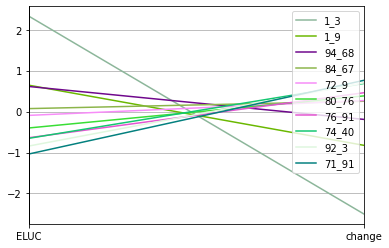

In [193]:
def plot_parallel_coordinates(gen: int, results_dir: Path):
    gen_df = create_pareto_df(gen, results_dir).iloc[:10]
    gen_df[OUTCOMES] = (gen_df[OUTCOMES] - gen_df[OUTCOMES].mean()) / gen_df[OUTCOMES].std()
    pd.plotting.parallel_coordinates(gen_df, "id", cols=OUTCOMES)

plot_parallel_coordinates(TOTAL_GENS, results_dir)

In [8]:
def get_gen_df(gen: int, results_dir: Path):
    gen_filename = results_dir / f"{gen}.csv"
    gen_df = pd.read_csv(gen_filename)
    # Sort by first objective, maximize: lowest to highest, minimize: highest to lowest
    gen_df = gen_df.sort_values(by='change', ascending=True)
    gen_df["Name"] = f"Gen {gen}"
    return gen_df

def get_all_gens_df(gens: list, results_dir: Path):
    dfs = []
    for gen in gens:
        dfs.append(get_gen_df(gen, results_dir))
    merged_df = pd.concat(dfs, ignore_index=True)
    return merged_df

In [9]:
def plot_all_gens(gens: list, outcomes: list[str], results_dir: Path, save_path=None):
    all_gens_df = get_all_gens_df(gens, results_dir)
    fig, ax = plt.subplots()

    all_gens_df.plot.scatter(x=outcomes[0],
                             y=outcomes[1],
                             ax=ax,
                             label="All prescriptors evaluated")
    # Plot last gen's pareto front in red
    
    #get_pareto_df(dir, gens[-1]).plot.scatter(x='change', y='ELUC', c='red', ax=ax, label="Gen 100 Pareto Front")
    overall_pareto = get_overall_pareto_df(gens[-1], results_dir)
    overall_pareto.plot.scatter(x=outcomes[0], y=outcomes[1], c='red', ax=ax, label="Final Pareto Front")
    plt.grid()
    #plt.title("All Generations All Prescriptor Performance")
    plt.legend(loc="upper left")
    if save_path:
        plt.savefig(save_path, format="png", dpi=300) 
    plt.show()

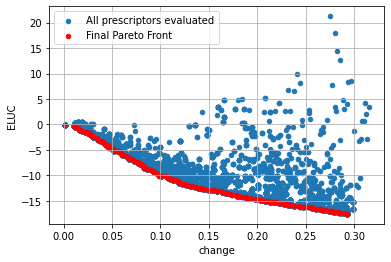

In [10]:
all_gens = [a + 1 for a in range(100)]
plot_all_gens(all_gens, ["change", "ELUC"], results_dir, save_path=None)
# plot_all_gens(all_gens, ["cropchange", "ELUC"], results_dir, save_path=None)
# plot_all_gens(all_gens, ["change", "cropchange"], results_dir, save_path=None)

In [11]:
all_pareto_df = get_overall_pareto_df(100, results_dir)

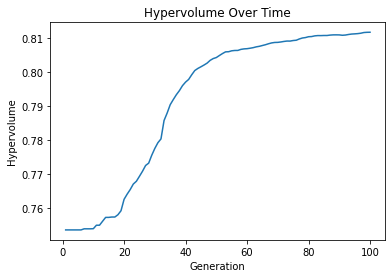

In [12]:
def plot_hypervolume(outcomes: list[str],
                     results_dir: Path,
                     ref_point=np.array([17.375717, 0.29098859373497826, 0.07468234]),
                     ideal=np.array([-17.375717, 0, 0]),):
    """
    Plots the hypervolume of our experiment.
    For the worst possible point we use -1 * the ideal eluc seed, and the 2 max changes from the seeds.
    For the best possible point we use the ideal eluc seed with 0 change.
    """
    nadir = ref_point
    metric = Hypervolume(ref_point=ref_point,
                         norm_ref_point=True,
                         zero_to_one=True,
                         ideal=ideal,
                         nadir=nadir)
    hypervolumes = []
    for gen in range(1, TOTAL_GENS+1):
        results_df = pd.read_csv(results_dir / f"{gen}.csv")
        F = results_df[outcomes].values
        hypervolumes.append(metric.do(F))


    plt.plot(range(1, TOTAL_GENS+1), hypervolumes)
    plt.xlabel("Generation")
    plt.ylabel("Hypervolume")
    plt.title("Hypervolume Over Time")
    plt.show()

plot_hypervolume(OUTCOMES, results_dir, ref_point=np.array([17.375717, 0.29098859373497826]), ideal=np.array([-17.375717, 0]))

## Comparison with Heuristic

In [26]:
def load_candidate(results_dir: Path, cand_id: str, cand_params: dict[str, int]) -> Candidate:
    cand_path = results_dir / str(int(cand_id.split('_')[0])+1) / f"{cand_id}.pt"
    cand = Candidate(**cand_params, device="mps", cand_id=cand_id)
    cand.load_state_dict(torch.load(cand_path))
    return cand

In [16]:
nn_serializer = NeuralNetSerializer()
nnp = nn_serializer.load(Path("predictors/trained_models/danyoung--eluc-global-nn"))
change_predictor = PercentChangePredictor()
cropchange_predictor = CropChangePredictor()
# predictors = {"ELUC": nnp, "change": change_predictor, "cropchange": cropchange_predictor}
predictors = {"ELUC": nnp, "change": change_predictor}

candidate_params = {"in_size": len(constants.CAO_MAPPING["context"]), "hidden_size": 16, "out_size": len(constants.RECO_COLS)}
# Set up new PrescriptorManager
cands = [load_candidate(results_dir, cand_id, candidate_params) for cand_id in all_pareto_df["id"]]
prescs = {cand.cand_id: LandUsePrescriptor(cand, encoder) for cand in cands}
torch_manager = PrescriptorManager(prescs, predictors)

In [17]:
test_df = dataset.test_df.sample(frac=0.01, random_state=100)
encoded_test_df = encoder.encode_as_df(test_df)

context_df = test_df[constants.CAO_MAPPING["context"]]
encoded_context_df = encoded_test_df[constants.CAO_MAPPING["context"]]

### Trained Prescriptors

In [18]:
def evaluate_prescriptor(prescriptor_manager: PrescriptorManager, cand_id: str, context_df: pd.DataFrame):
    context_actions_df = prescriptor_manager.prescribe(cand_id, context_df)
    outcome_df = prescriptor_manager.predict_metrics(context_actions_df)
    return [outcome_df[outcome].mean() for outcome in OUTCOMES]

In [19]:
assert len(all_pareto_df["id"].unique()) == len(all_pareto_df)

ids = all_pareto_df["id"].tolist()
elucs = []
changes = []
cropchanges = []
for cand_id in tqdm(ids):
    # eluc, change, cropchange = evaluate_prescriptor(torch_manager, cand_id, context_df)
    eluc, change = evaluate_prescriptor(torch_manager, cand_id, context_df)
    elucs.append(eluc)
    changes.append(change)
    # cropchanges.append(cropchange)

100%|██████████| 170/170 [01:06<00:00,  2.57it/s]


### Heuristics

In [21]:
pcts = [i/len(ids) for i in range(1, len(ids) + 1)]

linreg = LinearRegression()
linreg.fit(dataset.train_df[constants.DIFF_LAND_USE_COLS], dataset.train_df["ELUC"])
coefs = linreg.coef_
coef_dict = dict(zip(constants.LAND_USE_COLS, coefs))
reco_coefs = []
for col in constants.RECO_COLS:
    reco_coefs.append(coef_dict[col])
even_manager = PrescriptorManager({str(pct): EvenHeuristic(pct, "secdf") for pct in pcts}, predictors)
perfect_manager = PrescriptorManager({str(pct): PerfectHeuristic(pct, reco_coefs) for pct in pcts}, predictors)
# crop_manager = PrescriptorManager({str(pct): NoCropHeuristic(pct, reco_coefs) for pct in pcts}, predictors)

In [22]:
print(dict(zip(constants.RECO_COLS, reco_coefs)))

{'crop': 110.33926, 'pastr': 58.705685, 'range': 27.738625, 'secdf': -16.832415, 'secdn': 26.697311}


In [23]:
even_elucs, even_changes, even_cropchanges = [], [], []
perfect_elucs, perfect_changes, perfect_cropchanges = [], [], []
crop_elucs, crop_changes, crop_cropchanges = [], [], []
for pct in tqdm(pcts):
    # even_eluc, even_change, even_cropchange = evaluate_prescriptor(even_manager, str(pct), context_df)
    even_eluc, even_change = evaluate_prescriptor(even_manager, str(pct), context_df)
    even_elucs.append(even_eluc)
    even_changes.append(even_change)
    # even_cropchanges.append(even_cropchange)

    # perfect_eluc, perfect_change, perfect_cropchange = evaluate_prescriptor(perfect_manager, str(pct), context_df)
    perfect_eluc, perfect_change = evaluate_prescriptor(perfect_manager, str(pct), context_df)
    perfect_elucs.append(perfect_eluc)
    perfect_changes.append(perfect_change)
    # perfect_cropchanges.append(perfect_cropchange)

    # crop_eluc, crop_change, crop_cropchange = evaluate_prescriptor(crop_manager, str(pct), context_df)
    # crop_elucs.append(crop_eluc)
    # crop_changes.append(crop_change)
    # crop_cropchanges.append(crop_cropchange)

elucs, changes, cropchanges = np.array(elucs), np.array(changes), np.array(cropchanges)
even_elucs, even_changes, even_cropchanges = np.array(even_elucs), np.array(even_changes), np.array(even_cropchanges)
perfect_elucs, perfect_changes, perfect_cropchanges = np.array(perfect_elucs), np.array(perfect_changes), np.array(perfect_cropchanges)
crop_elucs, crop_changes, crop_cropchanges = np.array(crop_elucs), np.array(crop_changes), np.array(crop_cropchanges)

# trained_F = np.column_stack((elucs, changes, cropchanges))
# even_F = np.column_stack((even_elucs, even_changes, even_cropchanges))
# perfect_F = np.column_stack((perfect_elucs, perfect_changes, perfect_cropchanges))
# crop_F = np.column_stack((crop_elucs, crop_changes, crop_cropchanges))
trained_F = np.column_stack((elucs, changes))
even_F = np.column_stack((even_elucs, even_changes))
perfect_F = np.column_stack((perfect_elucs, perfect_changes))
crop_F = np.column_stack((crop_elucs, crop_changes))

100%|██████████| 170/170 [01:36<00:00,  1.77it/s]


100%|██████████| 185/185 [01:10<00:00,  2.63it/s]


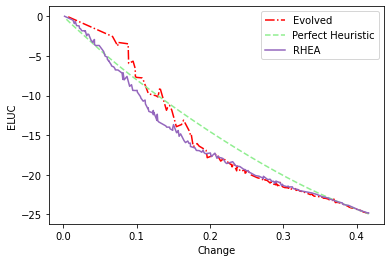

In [38]:
def compare_rhea(save_path=None):
    base_pareto_df = get_overall_pareto_df(100, Path("prescriptors/nsga2/training_runs/fixed-distance"))
    cands = [load_candidate(Path("prescriptors/nsga2/training_runs/fixed-distance"), cand_id, candidate_params) for cand_id in base_pareto_df["id"]]
    prescs = {cand.cand_id: LandUsePrescriptor(cand, encoder) for cand in cands}
    base_manager = PrescriptorManager(prescs, predictors)

    base_ids = base_pareto_df["id"].tolist()
    base_elucs = []
    base_changes = []
    for cand_id in tqdm(base_ids):
        # eluc, change, cropchange = evaluate_prescriptor(torch_manager, cand_id, context_df)
        base_eluc, base_change = evaluate_prescriptor(base_manager, cand_id, context_df)
        base_elucs.append(base_eluc)
        base_changes.append(base_change)

    base_elucs, base_changes = np.array(base_elucs), np.array(base_changes)
    base_F = np.column_stack((base_elucs, base_changes))

    base_idxs = np.argsort(base_F[:, 1])
    trained_idxs = np.argsort(trained_F[:, 1])
    perfect_idxs = np.argsort(perfect_F[:, 1])

    plt.plot(base_F[base_idxs, 1], base_F[base_idxs, 0], label="Evolved", color="red", linestyle="dashdot")
    plt.plot(perfect_F[perfect_idxs, 1], perfect_F[perfect_idxs, 0], label="Perfect Heuristic", color="lightgreen", linestyle="--")
    plt.plot(trained_F[trained_idxs, 1], trained_F[trained_idxs, 0], label="RHEA", color="C4")
    plt.xlabel("Change")
    plt.ylabel("ELUC")
    plt.legend()
    if save_path:
        plt.savefig(save_path, format="png", dpi=300)
    plt.show()

compare_rhea(figure_dir / "RHEA-pareto.png")

In [110]:
print(perfect_elucs[-1], perfect_changes[-1])
ref_point = np.array([0, perfect_changes[-1]])
ideal = np.array([perfect_elucs[-1], 0])
nadir = ref_point
metric = Hypervolume(ref_point=ref_point,
                        norm_ref_point=True,
                        zero_to_one=True,
                        ideal=ideal,
                        nadir=nadir)

trained_hv = metric.do(trained_F)
even_hv = metric.do(even_F)
perfect_hv = metric.do(perfect_F)

print(trained_hv, even_hv, perfect_hv)

-24.92859 0.416844439380585
0.5846012179327488 0.514089615850345 0.5686500357409842


### Comparison

In [111]:
def plot_heuristic_comparison(outcome_idxs: list[int], save_path=None):
    plt.scatter(trained_F[:, outcome_idxs[0]], trained_F[:, outcome_idxs[1]], label="Evolved Prescriptors", color="red")

    idx = np.argsort(even_F[:, outcome_idxs[0]])
    plt.plot(even_F[idx, outcome_idxs[0]], even_F[idx, outcome_idxs[1]], label="Even Heuristic", color="green")

    idx = np.argsort(perfect_F[:, outcome_idxs[0]])
    plt.plot(perfect_F[idx, outcome_idxs[0]], perfect_F[idx, outcome_idxs[1]], label="Perfect Heuristic", color="lightgreen")

    if "cropchange" in OUTCOMES:
        idx = np.argsort(crop_F[:, outcome_idxs[0]])
        plt.plot(crop_F[idx, outcome_idxs[0]], crop_F[idx, outcome_idxs[1]], label="No Crop Heuristic", color="orange")

    plt.legend()
    plt.xlabel(OUTCOMES[outcome_idxs[0]])
    plt.ylabel(OUTCOMES[outcome_idxs[1]])
    # plt.title(f"{OUTCOMES[outcome_idxs[0]]} vs {OUTCOMES[outcome_idxs[1]]}")
    if save_path:
        plt.savefig(save_path, format="png", dpi=300)
    plt.show()

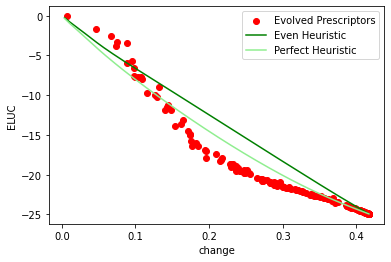

In [112]:
plot_heuristic_comparison([1, 0], save_path=figure_dir / "heuristic.png")
# plot_heuristic_comparison([2, 0])
# plot_heuristic_comparison([1, 2])

In [113]:
non_dom = []
for i in range(len(elucs)):
    dominated = False
    for j in range(len(elucs)):
        if elucs[i] > perfect_elucs[j] and changes[i] > perfect_changes[j]:
            dominated = True
        if elucs[i] < perfect_elucs[j] and changes[i] < perfect_changes[j]:
            dominated = False
            break
    if not dominated:
        non_dom.append(i)
non_dom = np.array(non_dom)
arr = np.zeros(len(elucs), dtype=bool)
arr[non_dom] = True
non_dom = arr

In [114]:
def get_idx_close(change: float, changes: np.ndarray) -> int:
    diff = np.abs(changes - change)
    idx = np.argmin(diff)
    return idx

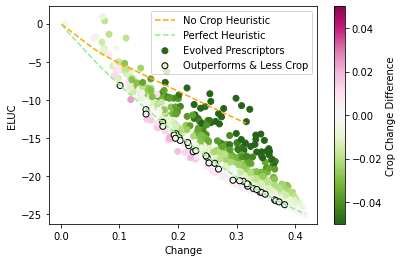

In [280]:
from matplotlib.colors import TwoSlopeNorm
from matplotlib.cm import ScalarMappable

def plot_cropchange(save_path=None):
    close_idxs = [get_idx_close(change, perfect_changes) for change in changes]

    cropchange_diff = cropchanges - perfect_cropchanges[close_idxs]

    # minmax = np.abs(cropchange_diff).max()
    minmax = 0.05
    norm = TwoSlopeNorm(vmin=minmax * -1, vcenter=0, vmax=minmax)

    non_dom_diff = non_dom & (cropchange_diff < 0)

    plt.plot(crop_changes, crop_elucs, label="No Crop Heuristic", color="orange", linestyle="--")
    plt.plot(perfect_changes, perfect_elucs, label="Perfect Heuristic", color="lightgreen", linestyle="--")

    # plt.scatter(changes, elucs, label="Trained", c=cropchange_diff, cmap="PiYG_r", norm=norm)
    plt.scatter(changes[~non_dom_diff], elucs[~non_dom_diff], label="Evolved Prescriptors", c=cropchange_diff[~non_dom_diff], cmap="PiYG_r", norm=norm)
    plt.scatter(changes[non_dom_diff], elucs[non_dom_diff], label="Outperforms & Less Crop", c=cropchange_diff[non_dom_diff], cmap="PiYG_r", edgecolors="black", norm=norm)

    mappable = ScalarMappable(norm=norm, cmap="PiYG_r")
    plt.colorbar(mappable, label="Crop Change Difference", ax=plt.gca())
    # plt.title("Crop Change Difference vs. Heuristics")
    plt.xlabel("Change")
    plt.ylabel("ELUC")
    plt.legend()
    if save_path:
        plt.savefig(save_path, format="png", dpi=300)
    plt.show()


plot_cropchange(figure_dir / "cropchange-diff.png")

In [273]:
close_idxs = [get_idx_close(change, perfect_changes) for change in changes]
cropchange_diff = cropchanges - perfect_cropchanges[close_idxs]
best_diff_idx = np.argsort(cropchange_diff[non_dom])[1]
close_idx = get_idx_close(changes[non_dom][best_diff_idx], perfect_changes)
print((changes[non_dom][best_diff_idx], elucs[non_dom][best_diff_idx], cropchanges[non_dom][best_diff_idx]), (perfect_changes[close_idx], perfect_elucs[close_idx], perfect_cropchanges[close_idx]))
print(cropchanges[non_dom][best_diff_idx] - perfect_cropchanges[close_idx])

(0.19661241724827042, -14.424579, 0.06516989) (0.1967911534233068, -14.355982, 0.0770641)
-0.011894204


In [115]:
ref_point=np.array([0, max(perfect_changes), max(perfect_cropchanges)])
ideal=np.array([min(perfect_elucs), 0, 0])

nadir = ref_point
metric = Hypervolume(ref_point=ref_point,
                        norm_ref_point=True,
                        zero_to_one=True,
                        ideal=ideal,
                        nadir=nadir)

trained_hv = metric.do(trained_F)
even_hv = metric.do(even_F)
perfect_hv = metric.do(perfect_F)
crop_hv = metric.do(crop_F)

plt.bar(["Trained", "Even Heuristic", "Perfect Heuristic", "No Crop Heuristic"],
        [trained_hv, even_hv, perfect_hv, crop_hv],
        color=["red", "green", "lightgreen", "orange"])
plt.ylim(0, 1)
plt.xticks(rotation=45)

plt.title("Test Set Hypervolume")
plt.xlabel("Generation")
plt.ylabel("Hypervolume")
plt.show()

type: max() arg is an empty sequence

## Examine Results

In [116]:
def get_idx_close(change, changes):
    diff = [abs(c - change) for c in changes]
    idx = diff.index(min(diff))
    return idx

def plot_selected_points(selected_points, save_path=None):
    for point_name, point in selected_points.items():
        marker = {}
        if point_name == "Trained Prescriptors":
            marker = {"marker": "x"}
        plt.scatter([point[0]], [point[1]], color=point[2], label=point_name, **marker)

    plt.legend()
    plt.xlabel("change")
    plt.ylabel("ELUC")
    plt.xlim([0, 0.4])
    plt.ylim([-25, 0])
    if save_path:
        plt.savefig(save_path, format="png", dpi=300)
    plt.show()

172


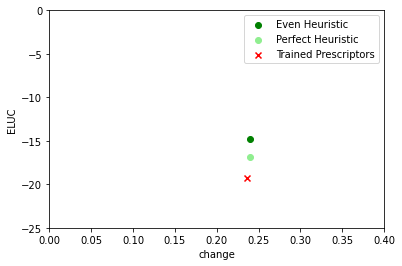

In [119]:
sort_idxs = np.argsort(changes)
changes_sorted = changes[sort_idxs]
elucs_sorted = elucs[sort_idxs]

# pct = 0.2
# idx = np.where(cropchange_diff == cropchange_diff[non_dom][best_diff_idx])[0][0]
idx = get_idx_close(pct, changes_sorted)
print(idx)
even_idx = get_idx_close(changes[idx], even_changes) + 1
perfect_idx = get_idx_close(changes[idx], perfect_changes) + 1
# crop_idx = get_idx_close(changes[idx], crop_changes) + 1


selected_points = {
    "Even Heuristic": (even_changes[even_idx], even_elucs[even_idx], "green"),
    "Perfect Heuristic": (perfect_changes[perfect_idx], perfect_elucs[perfect_idx], "lightgreen"),
    # "No Crop Heuristic": (crop_changes[crop_idx], crop_elucs[crop_idx], "orange"),
    "Trained Prescriptors": (changes[idx], elucs[idx], "red"),
}

plot_selected_points(selected_points)

In [122]:
def trained_prescribe_and_predict(prescriptor_manager: PrescriptorManager, cand_id: str, context_df: pd.DataFrame):
    context_actions_df = prescriptor_manager.prescribe(cand_id, context_df)
    outcome_df = prescriptor_manager.predict_metrics(context_actions_df)
    context_actions_df["ELUC"] = outcome_df["ELUC"]
    context_actions_df["change"] = outcome_df["change"]
    # context_actions_df["cropchange"] = outcome_df["cropchange"]
    return context_actions_df

In [123]:
# unsorted_idx = np.where(changes == changes_sorted[idx])[0][0]
unsorted_idx = idx
print(unsorted_idx)
trained_id = all_pareto_df["id"].iloc[unsorted_idx]
trained_result = trained_prescribe_and_predict(torch_manager, trained_id, context_df)

even_result = trained_prescribe_and_predict(even_manager, str(pcts[even_idx]), context_df)
perfect_result = trained_prescribe_and_predict(perfect_manager, str(pcts[perfect_idx]), context_df)
# no_crop_result = trained_prescribe_and_predict(crop_manager, str(pcts[crop_idx]), context_df)

172


/var/folders/4c/sd5grc691sx_dp1xqn1s9dyc0000gq/T/ipykernel_77933/1927802169.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df.loc[:,"geometry"] = result_df.apply(lambda row: Point(row["lon"], row["lat"]), axis=1)
/var/folders/4c/sd5grc691sx_dp1xqn1s9dyc0000gq/T/ipykernel_77933/1927802169.py:18: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


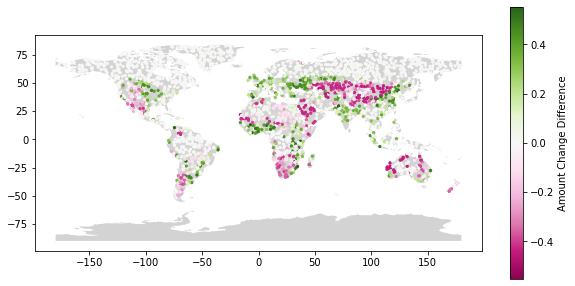

In [209]:
from shapely.geometry import Point
import geopandas as gpd
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

trained_result.head()
def plot_map(result_df: pd.DataFrame, outcome: str, save_path=None):
    if outcome == "ELUC" or outcome == "change_diff" or outcome == "ELUC_diff":
        min_max = max(abs(result_df[outcome].min()), abs(result_df[outcome].max()))
        norm = TwoSlopeNorm(vmin=-1 * min_max, vcenter=0, vmax=min_max)
        cmap = "PiYG_r" if outcome == "ELUC" or outcome == "ELUC_diff" else "PiYG"
    if outcome == "change":
        norm = None
        cmap = "Greens"
    result_df.loc[:,"geometry"] = result_df.apply(lambda row: Point(row["lon"], row["lat"]), axis=1)
    gdf = gpd.GeoDataFrame(result_df, geometry="geometry")
    gdf.set_crs(epsg=4326, inplace=True)
    world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    fig, ax = plt.subplots(figsize=(10, 10))
    world.plot(ax=ax, color='lightgrey')
    ax.scatter(gdf.geometry.x, gdf.geometry.y, c=result_df[outcome], cmap=cmap, norm=norm, s=5)
    fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax, label="Amount Change Difference", shrink=0.5)
    if save_path:
        plt.savefig(save_path, format="png", dpi=300, bbox_inches="tight")
    plt.show()
trained_result["change_diff"] = trained_result["change"] - perfect_result["change"]
trained_result["ELUC_diff"] = trained_result["ELUC"] - perfect_result["ELUC"]

# plot_map(trained_result[trained_result["time"] == 2021], "change")
# plot_map(trained_result[trained_result["time"] == 2021], "ELUC")
plot_map(trained_result[trained_result["time"] == 2021], "change_diff", save_path=figure_dir / "change-diff-map.png")
# plot_map(trained_result[trained_result["time"] == 2021], "ELUC_diff")

In [124]:
def plot_expanded(result_dict: dict, save_path=None):
    # Evolved first so that it is on the bottom
    for sample_name, result in result_dict.items():
        plt.scatter(result[0], result[1], color=result[2], label=sample_name)
    
    # Rearrange legend (from stackoverflow)
    # handles, labels = plt.gca().get_legend_handles_labels()
    # order = [1, 2, 0]
    # plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])
    plt.legend()
    plt.xlabel("change")
    plt.ylabel("ELUC")
    #plt.title("Expanded view of ~20% change prescriptors (subsampled)")
    if save_path:
        plt.savefig(save_path, format="png", dpi=300)
    plt.show()

242


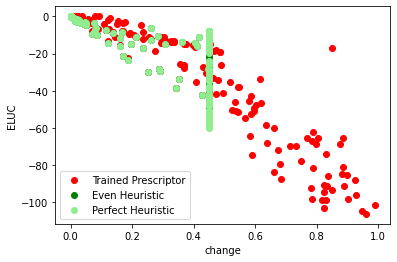

In [125]:
sample =  trained_result.sample(frac=0.01, random_state=42)
print(len(sample))
even_sample = even_result.loc[sample.index]
perfect_sample = perfect_result.loc[sample.index]
# no_crop_sample = no_crop_result.loc[sample.index]

expanded_results = {
    "Trained Prescriptor": (sample["change"], sample["ELUC"], "red"),
    "Even Heuristic": (even_sample["change"], even_sample["ELUC"], "green"),
    "Perfect Heuristic": (perfect_sample["change"], perfect_sample["ELUC"], "lightgreen"),
    # "No Crop Heuristic": (no_crop_sample["change"], no_crop_sample["ELUC"], "orange"),
}

plot_expanded(expanded_results)

In [156]:
def create_diff_df(trained_result, perfect_result):
    eluc_diff = trained_result["ELUC"] - perfect_result["ELUC"]
    change_diff = trained_result["change"] - perfect_result["change"]
    diff_df = pd.concat([eluc_diff, change_diff], axis=1)

    return diff_df

In [157]:
trained_diff = create_diff_df(sample, perfect_sample)

In [158]:
def plot_diffs(diff_df, save_path=None):
    
    dom = diff_df[(diff_df["change"] < 0) & (diff_df["ELUC"] < 0)]
    other_dom = diff_df[(diff_df["change"] > 0) & (diff_df["ELUC"] > 0)]

    plt.scatter(diff_df["change"], diff_df["ELUC"], label="No domination")
    plt.scatter(other_dom["change"], other_dom["ELUC"], color="lightgreen", label="Perfect Heuristic dominates")
    plt.scatter(dom["change"], dom["ELUC"], color="red", label="Evolved Prescriptor dominates")
    plt.axhline(0, color="black", linestyle="--")
    plt.axvline(0, color="black", linestyle="--")
    plt.xlabel("Change Difference")
    plt.ylabel("ELUC Difference")
    #plt.title("Change Diff vs. ELUC Diff Between Trained and Perfect (subsampled)")
    plt.legend()
    if save_path:
        plt.savefig(save_path, format="png", dpi=300)
    plt.show()

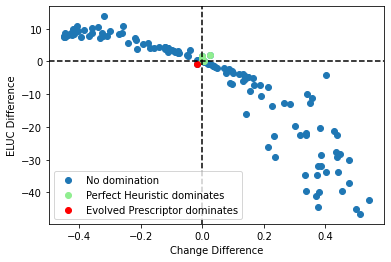

In [159]:
plot_diffs(trained_diff)

In [160]:
def display_dominating(diff_df):
    low_change_idx = diff_df["change"][(diff_df["change"] < 0)].index
    low_change_eluc_diff = diff_df["ELUC"][low_change_idx]
    low_change_neg_eluc_diff = low_change_eluc_diff[low_change_eluc_diff < 0]
    print(f"Number less change better ELUC: {len(low_change_neg_eluc_diff)}")
    if len(low_change_neg_eluc_diff) > 0:
        min_idx = low_change_neg_eluc_diff.sort_values().index[0]
        print(f"Max difference in ELUC with less change: {diff_df['ELUC'][min_idx]}")

    signif = low_change_neg_eluc_diff[abs(low_change_neg_eluc_diff) > 0.05]
    print(f"Number of points where trained prescriptor prescribes less change than perfect heuristic AND produces better ELUC by more than predictor model MAE: {len(signif)}")
    print(f"Average difference in change for these points: {diff_df['change'].loc[signif.index].mean()}")
    print(f"Average difference in ELUC for these points: {signif.mean()}")
    print()

In [161]:
display_dominating(trained_diff)

Number less change better ELUC: 1
Max difference in ELUC with less change: -0.7613697052001953
Number of points where trained prescriptor prescribes less change than perfect heuristic AND produces better ELUC by more than predictor model MAE: 1
Average difference in change for these points: -0.018703609704971313
Average difference in ELUC for these points: -0.7613697052001953



In [162]:
def plot_avg_presc(result_dict, save_path=None):
    xticks = np.arange(len(constants.DIFF_RECO_COLS))
    i = 0
    width = 1 / (len(result_dict) + 1)
    for result_name, result in result_dict.items():
        plt.bar(xticks + i * width, result[0][constants.DIFF_RECO_COLS].mean(), width=width, label=result_name, color=result[1])
        i += 1
    
    plt.xticks(xticks + (len(result_dict)-1)/2 * width, constants.DIFF_RECO_COLS, rotation=90)
    plt.legend()
    plt.grid()
    #plt.title("Average land use change for each prescriptor")
    fig = plt.gcf()
    fig.set_tight_layout(True)
    if save_path:
        plt.savefig(save_path, format="png", dpi=300)
    plt.show()

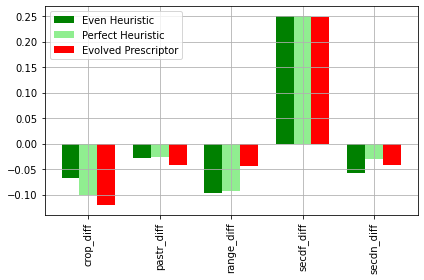

In [163]:
plot_avg_presc({
    "Even Heuristic": (even_sample, "green"),
    "Perfect Heuristic": (perfect_sample, "lightgreen"),
    # "No Crop Heuristic": (no_crop_sample, "orange"),
    "Evolved Prescriptor": (sample, "red"),
}, save_path=figure_dir / "crop-diff-changes.png")

#### See what features cause more change

In [165]:
def plot_corrs(result_df, save_path=None):
    rs = []
    for col in constants.LAND_USE_COLS + constants.NONLAND_FEATURES:
        feat = result_df[col]
        if col == "lat" or col == "lon":
            feat = abs(feat)
        rs.append(feat.corr(result_df["change"]))
    print(rs)

    labels = constants.LAND_USE_COLS + constants.NONLAND_FEATURES
    labels[labels.index("lat")] = "abs(lat)"
    labels[labels.index("lon")] = "abs(lon)"
    plt.bar(labels, rs)
    plt.xticks(rotation=90)
    plt.xlabel("Context Feature")
    plt.ylabel("r value")
    plt.title("Linear Correlation Between Context and Amount of Prescribed Change")
    plt.grid(axis="y")
    if save_path:
        plt.savefig(save_path, format="png", dpi=300)
    plt.show()

[0.7897765960632552, 0.6055556307438081, -0.32284198701077044, -0.24699849706243104, -0.09733518105266592, -0.14409601182833515, 0.38085407203708743, 0.1361491497047347, 0.4133942406178987, -0.3611449698666315, -0.3045767864011862, 0.017025171678494083]


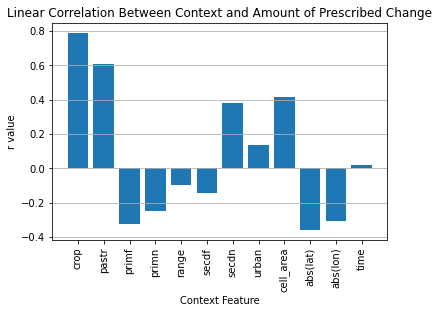

In [166]:
plot_corrs(trained_result)

In [70]:
def plot_context_change(trained_sample, feature, save):
    plt.scatter(trained_sample[feature], trained_sample["change"])
    plt.title(f"Context {feature} vs. Amount of Prescribed Change")
    plt.ylabel("Change")
    plt.xlabel(feature)
    if feature in constants.LAND_USE_COLS:
        plt.plot([0, 1], [0, 1], color="black", linestyle="--", label="y=x")
        plt.plot([0, 1], [1, 0], color="red", linestyle="--", label="y=1-x")
        plt.legend()
    if save:
        plt.savefig(f"figures/{feature}change.png", format="png", dpi=300)
    plt.show()

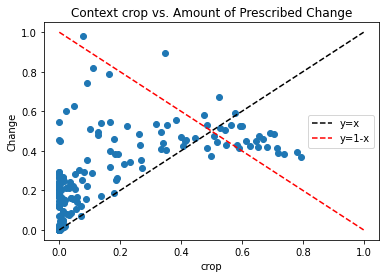

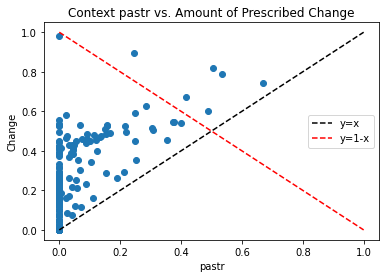

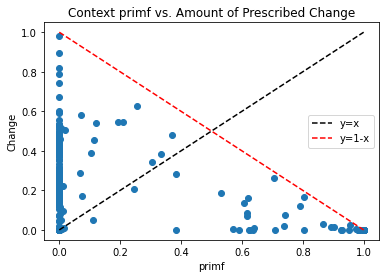

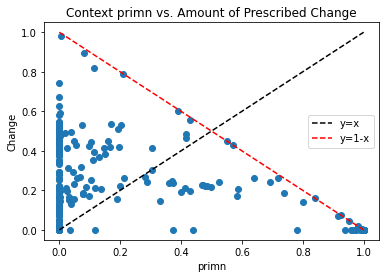

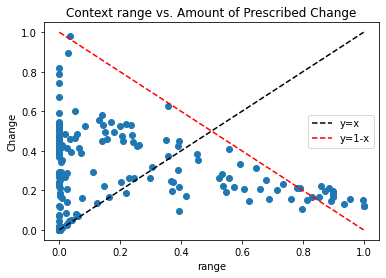

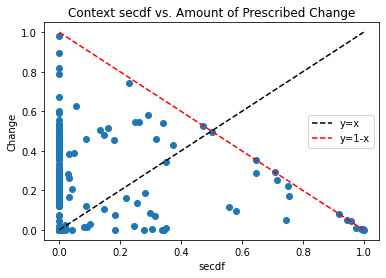

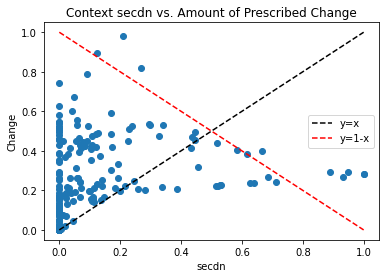

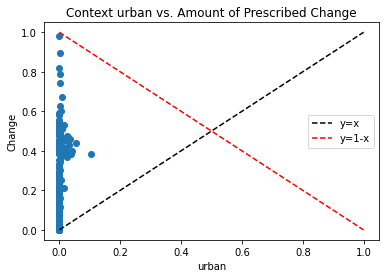

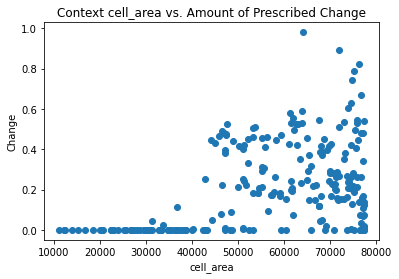

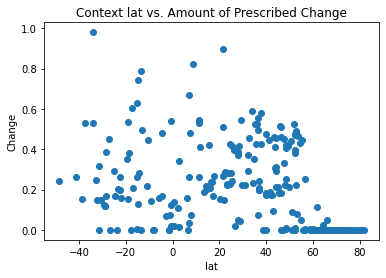

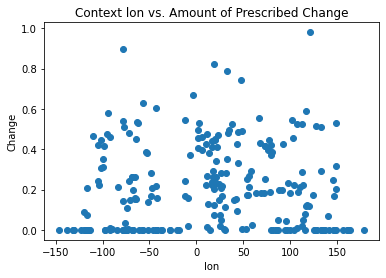

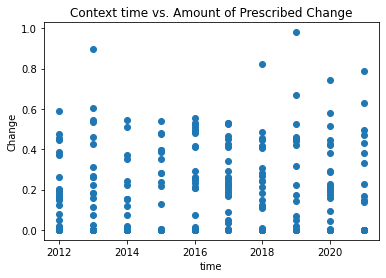

In [71]:
for feature in constants.LAND_USE_COLS + constants.NONLAND_FEATURES:
    plot_context_change(sample, feature, False)

## Compare to Global Warming

In [50]:
pcts = [0.01, 0.05, 0.1, 0.2, 0.5, 1]
total_emissions = []
total_changes = []
warming_manager = PrescriptorManager({str(pct): PerfectHeuristic(pct, reco_coefs) for pct in pcts}, predictors)
for pct in tqdm(pcts):
    result_df = warming_manager.prescribe(str(pct), dataset.test_df.loc[2021][constants.CAO_MAPPING["context"]])
    outcome_df = perfect_manager.predict_metrics(result_df)
    result_df["ELUC"] = outcome_df["ELUC"]
    result_df["change"] = outcome_df["change"]
    result_df["total_emissions"] = result_df["ELUC"] * result_df["cell_area"]
    result_df["total_change"] = result_df["change"] * result_df["cell_area"]
    total_emissions.append(result_df["total_emissions"].sum())
    total_changes.append(result_df["total_change"].sum() / result_df["cell_area"].sum())

100%|██████████| 6/6 [00:10<00:00,  1.67s/it]


In [51]:
# Weight of CO2 vs. C
conversion = 3.664
# Remaining Carbon budget
rcb = 250
rcb2 = 1200
# Yearly net emissions
yearly = 20

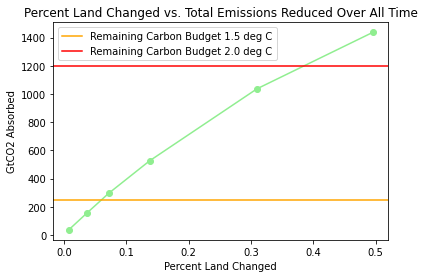

In [52]:
fig = plt.figure(facecolor="white")
plt.plot(total_changes, [-1 * t * conversion / 1e9 for t in total_emissions], marker="o", color="lightgreen")
plt.axhline(y=rcb, color='orange', label="Remaining Carbon Budget 1.5 deg C")
plt.axhline(y=rcb2, color='red', label="Remaining Carbon Budget 2.0 deg C")
plt.legend()
plt.title("Percent Land Changed vs. Total Emissions Reduced Over All Time")
plt.ylabel("GtCO2 Absorbed")
plt.xlabel("Percent Land Changed")
plt.show()

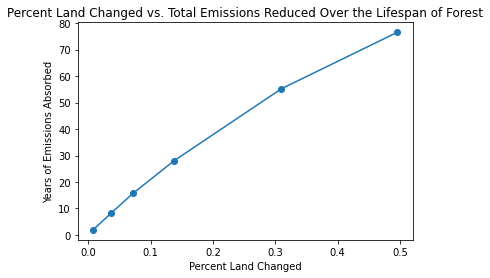

In [53]:
fig = plt.figure(facecolor="white")
plt.plot(total_changes, [t / (-18.78e9 / conversion) for t in total_emissions], marker="o")
plt.title("Percent Land Changed vs. Total Emissions Reduced Over the Lifespan of Forest")
plt.xlabel("Percent Land Changed")
plt.ylabel("Years of Emissions Absorbed")
plt.show()